**Group information** <br> 

| Family name | First name | Student #  | BSE email             | <br> 
| Quinones    | Luis       | 1678037    | luis.quinones@bse.eu  | <br> 
| Pfeiffer    | Tobias     | 1678033    | tobias.pfeiffer@bse.eu | <br> 

# Deep learning applications - Homework 1

This practice session aims to extract automatically building footprints from aerial images of the state of Massachusetts. We want to approximate the function mapping input images to a binary prediction for each pixel (i.e. semantic segmentation) using the U-Net convolutional network architecture [(Ronneberger et al. 2015)](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). For this assignment, the GPU implementation of TensorFlow is recommended, but students preferring PyTorch can use this framework instead.

The image data consists of 3347 colour raster of dimension 256x256x3 using the NAD83 (EPSG:26986) projection system. Each raster represents an area of 300 square meters. The label data consists of building footprints vectors extracted from [OpenStreetMap](https://www.openstreetmap.org/relation/61315) and converted into a binary raster with the same extent and resolution as the image rasters. The unformatted data was provided by Minh (2013) and can be accessed on his [website](http://www.cs.toronto.edu/~vmnih/data/). Images and labels are randomly partitioned into a training (70%) validation (15%) and test sample (15%).

Tensorflow Keras documentation:
- [Convolution](https://keras.io/api/layers/convolution_layers/)
- [Activation](https://keras.io/api/layers/activations/)
- [Pooling](https://keras.io/api/layers/pooling_layers/)
- [Regularisation](https://keras.io/api/layers/regularization_layers/)
- [Optimisers](https://keras.io/api/optimizers/)
- [Metrics](https://keras.io/api/metrics/)
- [Losses](https://keras.io/api/losses/)
- [Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)

![U-Net model](homework_model.jpg)

In [1]:
# Modules
import numpy as np

import tensorflow
from tensorflow import keras
from tensorflow.keras import callbacks, layers, losses, metrics, models, optimizers, preprocessing, utils
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from homework_utilities import *
import matplotlib as plt

In [2]:
# Checks tensorFlow
print('TensorFlow version:', tensorflow.__version__)
print('GPU available:', len(tensorflow.config.list_physical_devices('GPU')))

# Defines paths
paths = dict(
    images_train='data/training/images',
    labels_train='data/training/labels',
    images_valid='data/validation/images',
    labels_valid='data/validation/labels',
    images_test= 'data/test/images',
    labels_test= 'data/test/labels'
)

TensorFlow version: 2.12.0
GPU available: 0


1. Load the images and labels for the training and validation samples as separate `numpy.ndarray` of dimensions $n \times h \times w \times d$. You can use the provided `search_files` and `read_raster` utility functions. Normalise the images between 0 and 1 and set the labels data type as float.

In [3]:
def gen_dataset(dir_path_image: str, dir_path_label: str):
    '''Loads data into np.ndarrays'''
    image_path = search_files(dir_path_image)
    label_path = search_files(dir_path_label)
    i = []
    l = []
    for path in image_path:
        i.append(path)
    
    for path in label_path:
        l.append(path)
    
    image = []
    label = []
    for obj in i:
        image.append(read_raster(obj))

    for obj in l:
        label.append(read_raster(obj))        
    image = np.multiply(image, (1/255))
    label = np.stack(label)
    return image, label

In [4]:
train_image, train_label = gen_dataset(paths['images_train'], paths['labels_train'])
test_image, test_label = gen_dataset(paths['images_test'], paths['labels_test'])
validation_image, validation_label = gen_dataset(paths['images_valid'], paths['labels_valid'])

2. For the training and validation samples, check the dimensions of the images and labels arrays. Display several matching image and label pairs to ensure correspondence. You can use the provided `compare` utility function.

In [5]:
def dimensions(image_array, label_array):
    # the NN expects a np.ndarry an input annd output
    if not isinstance(image_array, np.ndarray) or not isinstance(label_array, np.ndarray):
        raise TypeError("Inputs must be numpy ndarrays")
    
    image_shape = image_array.shape
    label_shape = label_array.shape

    if (image_shape[0] == label_shape[0]) and (image_shape[1] == label_shape[1]) and (image_shape[2] == label_shape[2]) and (image_shape[3] == 3) and (label_shape[3] == 1):
        print('The Dimensions are correct')
    else:
        print('The dimensions are incorrect. Check the data function')

In [6]:
dimensions(train_image, train_label)
dimensions(validation_image, validation_label)

The Dimensions are correct
The Dimensions are correct


3. Using the Keras functional API, define a simplified U-Net model with the number of kernels indicated in the figure above (i.e. 8, 16, 32, 64, 128, ...). There are numerous implementation examples of U-Nets using Keras. Choose the appropriate activation functions for the hidden layers and the output layer, and the corresponding parameter initialisation method.

In [7]:
def encoder(imp, filters, kernel_size=(3, 3), padding="same", strides=1):
    # imp = input, filters = reduce/compact the pixel dimesion
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(imp)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    # returns the first layer which is fed to the decoders (see image)
    # p is the encoder block
    return c, p

def decoder(imp, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    '''
    imp = imput
    skip = the layer from the encoder block that is concatenated (see blue line in graphic)
    filter = reduce/compact the pixel dimesion
    '''
    # concatenate imput and encoder layer
    us = keras.layers.UpSampling2D((2, 2))(imp)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    # 4 encoder block; mistake may lay here
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(imp, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(imp)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [8]:
def u_net():
    f = [8, 16, 32, 64, 128, 256]
    inputs = keras.layers.Input((256, 256, 3))
    
    p0 = inputs
    c1, p1 = encoder(p0, f[0]) #256 -> 128
    c2, p2 = encoder(p1, f[1]) #128 -> 64
    c3, p3 = encoder(p2, f[2]) #64 -> 32
    c4, p4 = encoder(p3, f[3]) #32 -> 16
    c5, p5 = encoder(p4, f[4]) #16 -> 8
    
    bn = bottleneck(p5, f[5])
    
    u1 = decoder(bn, c5, f[4]) #8 -> 16
    u2 = decoder(u1, c4, f[3]) #16 -> 32
    u3 = decoder(u2, c3, f[2]) #32 -> 64
    u4 = decoder(u3, c2, f[1]) #64 -> 128
    u5 = decoder(u4, c1, f[0]) #128 -> 256
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u5)
    model = keras.models.Model(inputs, outputs)
    return model

4. Initialise and compile the model using the chosen optimisation algorithm and the appropriate loss function. Optionally, you can use the focal version of the loss function to account for the class imbalance in the training data. Print the model structure using the `summary` method.

In [9]:
model = u_net()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 8)  0           ['conv2d_1[0][0]']           

5. Estimate the model parameters using the training and the validation sample. Use batch-size of 32 and a maximum of 30 training epoch. Use an early-stopping callback with a patience parameter of 3 to recover the parameters that minimise the error on the validation sample.

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(train_image, train_label, batch_size=32, epochs=30, validation_data=(validation_image, validation_label), callbacks=[early_stopping])

Epoch 1/30
74/74 [==============================] - 548s 7s/step - loss: 0.4053 - acc: 0.8849 - val_loss: 0.3191 - val_acc: 0.8827
Epoch 2/30
74/74 [==============================] - 549s 7s/step - loss: 0.2943 - acc: 0.8851 - val_loss: 0.2686 - val_acc: 0.8827
Epoch 3/30
74/74 [==============================] - 544s 7s/step - loss: 0.2461 - acc: 0.8948 - val_loss: 0.2299 - val_acc: 0.9078
Epoch 4/30
74/74 [==============================] - 553s 7s/step - loss: 0.2151 - acc: 0.9139 - val_loss: 0.2294 - val_acc: 0.9109
Epoch 5/30
74/74 [==============================] - 534s 7s/step - loss: 0.2089 - acc: 0.9160 - val_loss: 0.2116 - val_acc: 0.9161
Epoch 6/30
74/74 [==============================] - 525s 7s/step - loss: 0.1925 - acc: 0.9219 - val_loss: 0.1891 - val_acc: 0.9218
Epoch 7/30
74/74 [==============================] - 513s 7s/step - loss: 0.1843 - acc: 0.9248 - val_loss: 0.2000 - val_acc: 0.9215
Epoch 8/30
74/74 [==============================] - 493s 7s/step - loss: 0.1813 - a

In [11]:
model.save('my_model', save_format='h5')

6. Display the evolution of the training and validation metrics during training using the provided `display_history` utility function. Load and format the test sample (see question 1) and evaluate the model's generalisation performance.

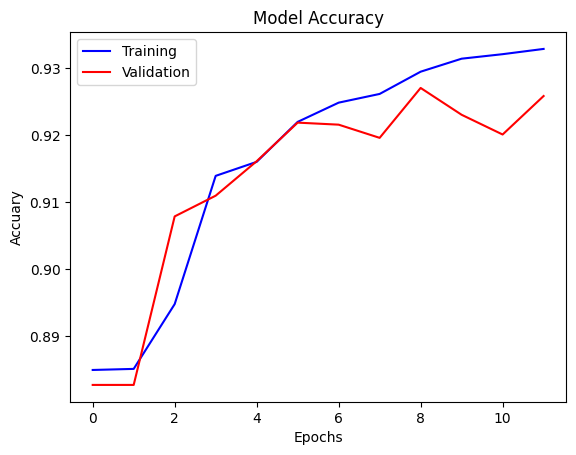

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], color='b')
plt.plot(history.history['val_acc'], color='r')
plt.title('Model Accuracy')
plt.ylabel('Accuary')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

7. Compute the predicted probabilities for the test images. Turn the probabilities into binary predictions using a threshold of 0.5. Display prediction statistics using the provided `display_statistics` utility for several test images.

In [20]:
predictions = model.predict(test_image)
print(predictions[0])

16/16 [==============================] - 23s 1s/step
[[[0.23833506]
  [0.16609949]
  [0.13645825]
  ...
  [0.03225291]
  [0.04361745]
  [0.11271518]]

 [[0.1380225 ]
  [0.0785538 ]
  [0.05665174]
  ...
  [0.00641345]
  [0.00786291]
  [0.0426072 ]]

 [[0.09705142]
  [0.05381451]
  [0.04366969]
  ...
  [0.00258298]
  [0.00354438]
  [0.02643957]]

 ...

 [[0.18671352]
  [0.14278294]
  [0.12406482]
  ...
  [0.01021862]
  [0.0145861 ]
  [0.07661316]]

 [[0.17382307]
  [0.1115804 ]
  [0.08739115]
  ...
  [0.00654323]
  [0.01264463]
  [0.07704383]]

 [[0.2428641 ]
  [0.17885193]
  [0.14600404]
  ...
  [0.02331771]
  [0.04680862]
  [0.17636293]]]


In [21]:
predictions[0].shape

(256, 256, 1)

8. **OPTIONAL** Modify the network with either batch-normalisation or spatial dropout layers to increase predictive performance. Assuming that we give equal importance to reducing false positives and false negatives, use a decision probability threshold that strikes the best balance between these two quantities.